# Rede MLP - predição de preços

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib ipympl

In [2]:
# Exibe a versão instalada do tensorflow
print(tf.__version__)

2.13.0


### Coleta dos dados

Os dados são coletados do Yahoo Finance por meio da biblioteca yfinance.

In [3]:
# Ativo para predição de preços
SYMBOL = 'BTC-USD'

In [4]:
# Coleta os dados de preço do ativo em um timeframe diário e retorna um dataframe dos dados
data = yf.download(SYMBOL, period='max')

[*********************100%***********************]  1 of 1 completed


In [5]:
# Remove a coluna Adj Close do dataframe
data = data.drop(['Adj Close'], axis='columns')

# Obtém somente os dados de preço até o dia anterior ao atual
data = data.iloc[:len(data) - 1]

# Ordena as colunas do dataframe
data = data[['Open', 'High', 'Low', 'Volume', 'Close']]

# Exibe alguns detalhes do dataframe
data.info()
print()

# Exibe uma amostra dos 5 primeiros elementos do dataframe
data.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3307 entries, 2014-09-17 to 2023-10-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3307 non-null   float64
 1   High    3307 non-null   float64
 2   Low     3307 non-null   float64
 3   Volume  3307 non-null   int64  
 4   Close   3307 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 155.0 KB



,Open,High,Low,Volume,Close
Date,,,,,
2023-10-02,27976.798828,28494.458984,27347.787109,19793041322,27530.785156
2023-10-03,27508.251953,27667.191406,27216.001953,11407814187,27429.978516
2023-10-04,27429.074219,27826.658203,27248.105469,11143355314,27799.394531
2023-10-05,27798.646484,28091.861328,27375.601562,11877253670,27415.912109
2023-10-06,27412.123047,28252.537109,27215.552734,13492391599,27946.597656


### Pré-processamento dos dados

Os dados são separados em dois conjuntos de treino e teste, e cada conjunto possui as suas entradas (x) e as suas respectivas saídas rotuladas (y).
- As entradas são compostas pelos preços Open, High, Low, Close e Volume do dia anterior.
- As saídas rotuladas são compostas pelos preços de fechamento (Close).

Também é feito a normalização destes dados com a biblioteca scikit-learn. A normalização dos dados tem a finalidade de transformar os dados para que os valores estejam em uma mesma escala. Utilizar a classe MinMaxScaler para transformar os valores em uma escala entre -1 e 1.

In [6]:
# Separa os dados de treinamento e testes
data_train, data_test = train_test_split(data, test_size=0.1, shuffle=False) # 10% dos dados para testes

# Exibe uma amostra e o formato dos dados de treino
print(f'Dados de treino shape: {data_train.values.shape}')
data_train.head(7)

Dados de treino shape: (2976, 5)


,Open,High,Low,Volume,Close
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,21056800,457.334015
2014-09-18,456.859985,456.859985,413.104004,34483200,424.440002
2014-09-19,424.102997,427.834991,384.532013,37919700,394.795990
2014-09-20,394.673004,423.295990,389.882996,36863600,408.903992
2014-09-21,408.084991,412.425995,393.181000,26580100,398.821014
2014-09-22,399.100006,406.915985,397.130005,24127600,402.152008
2014-09-23,402.092010,441.557007,396.196991,45099500,435.790985


In [7]:
# Exibe uma amostra e o formato dos dados de teste
print(f'Dados de teste shape: {data_test.values.shape}')
data_test.head(7)

Dados de teste shape: (331, 5)


,Open,High,Low,Volume,Close
Date,,,,,
2022-11-10,15883.158203,18054.312500,15834.018555,83202283721,17586.771484
2022-11-11,17583.251953,17650.943359,16543.482422,55871616488,17034.292969
2022-11-12,17036.875000,17066.675781,16651.775391,29717699419,16799.185547
2022-11-13,16799.722656,16920.765625,16320.634766,27209183682,16353.365234
2022-11-14,16352.028320,17109.324219,15872.941406,49630243054,16618.199219
2022-11-15,16617.484375,17051.962891,16542.550781,36599436183,16884.613281
2022-11-16,16884.341797,16960.294922,16430.111328,33925512989,16669.439453


In [8]:
# Define o tamanho da janela dos dados de entrada dos dias anteriores. 
# A arquitetura ANN (Multilayer Perceptron) não suporta múltiplos timesteps.
timesteps = 1

In [9]:
# Cria janelas deslizante de dados
def create_data_window(data, timesteps):
    x = []
    y = []
    
    for i in range(len(data) - 1): # -1 pois a última linha dos dados será para o label (y)
        x.append(data[i, :]) # Inputs do dia 
        y.append(data[i+1, [-1]]) # Preço de fechamento do dia seguinte 
    
    return np.array(x), np.array(y)

In [10]:
# Objeto para normalização dos dados em uma escala entre -1 e 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Transforma os dados em uma escala entre -1 e 1
data_train_norm = scaler.fit_transform(data_train)
data_test_norm = scaler.transform(data_test)

In [11]:
# Separa os inputs e labels dos dados de treino e teste
x_train, y_train = create_data_window(data_train_norm, timesteps)
x_test, y_test = create_data_window(data_test_norm, timesteps)

# Exibe o formato dos dados de treino
print(f'Formato dos dados x_train: {x_train.shape}')
print(f'Formato dos dados y_train: {y_train.shape}')
print()

# Exibe o formato dos dados de teste
print(f'Formato dos dados x_test: {x_test.shape}')
print(f'Formato dos dados y_test: {y_test.shape}')
print()

# Exibe uma amostra dos dados de teste
print(x_test[-1])
print()
print(y_test[-1])

Formato dos dados x_train: (2975, 5)
Formato dos dados y_train: (2975, 1)

Formato dos dados x_test: (330, 5)
Formato dos dados y_test: (330, 1)

[-0.18003306 -0.1869062  -0.17825511 -0.93234972 -0.19162118]

[-0.1758712]


### Construção e treinamento da rede neural

O modelo construído neste notebook, é um rede neural MLP com as seguintes definições:
- Modelo sequencial da API Keras do tensorflow.
- Camada de entrada com 5 features refererentes aos dados de preços (Open, High, Low, Volume, Close).
- 1 camada oculta com 64 neurônios que utilizam a função de ativação tanh.
- 1 camada de saída para fazer a predição do próximo preço de fechamento (próximo dia).

In [12]:
# Cria um modelo de rede neural MLP
model = keras.Sequential(name='ANN_ONE-STEP-FORECAST')
model.add(layers.Dense(units=64, activation='tanh', input_shape=(x_train.shape[1],))) # Funções de ativaçõo: sigmoid, tanh, relu, elu, selu
model.add(layers.Dense(1))

# Define o algoritmo otimizador dos pesos da rede neural e a taxa de aprendizado
opt = keras.optimizers.Adam(learning_rate=0.001) # learning_rate=0.001 por padrão

# Compila o modelo definindo a função de perda para cálculo do erro e o algoritmo otimizador.
model.compile(loss='mae', optimizer=opt) # Funções de perda para testar: mae, mse, msle, huber, log_cosh

In [13]:
# Exibe algumas informações do modelo
print(model.summary())

Model: "ANN_ONE-STEP-FORECAST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 449 (1.75 KB)
Trainable params: 449 (1.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [14]:
%%time

# Treina o modelo
history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/100
93/93 [==============================] - 1s 3ms/step - loss: 0.2476 - val_loss: 0.0198
Epoch 2/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0147
Epoch 3/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0185 - val_loss: 0.0178
Epoch 4/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0167 - val_loss: 0.0142
Epoch 5/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0121
Epoch 6/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0171 - val_loss: 0.0121
Epoch 7/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0154 - val_loss: 0.0132
Epoch 8/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0126
Epoch 9/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0153 - val_loss: 0.0223
Epoch 10/100
93/93 [==============================] - 0s 2ms/step - loss: 0.0178 - val_loss: 0.0129
Epoch 11/

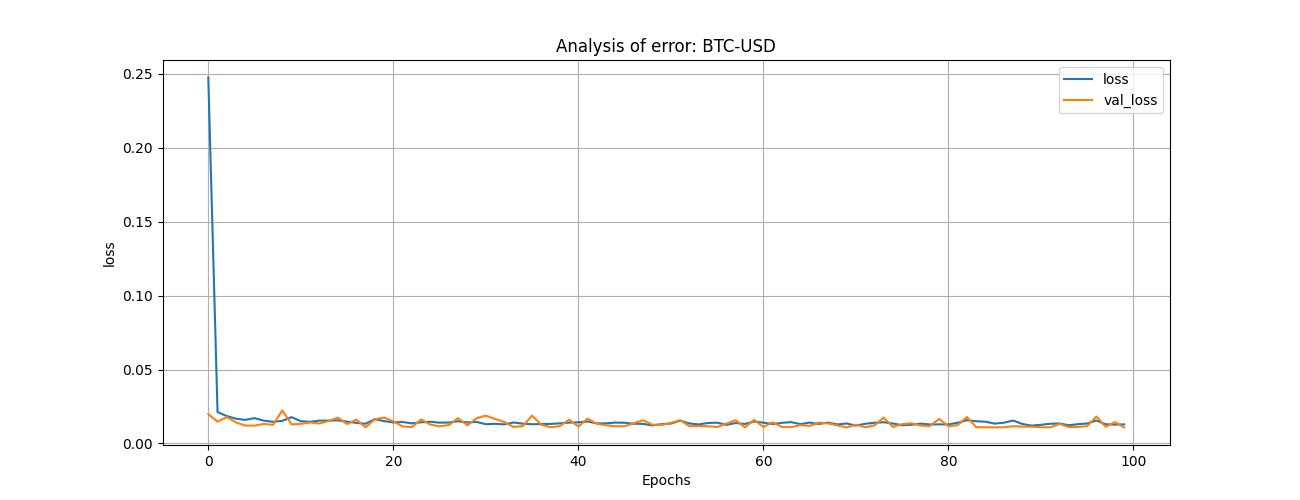

In [25]:
# Mostra o gráfico do erro da rede neural

def plot_graph(history, string):
    plt.figure(figsize=(13,5))
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    
    plt.title(f'Analysis of error: {SYMBOL}')
    plt.legend([string, 'val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel('loss')
    plt.grid()
    #plt.yscale('log')
    plt.show()

# Plota a evolução do erro ao decorrer das épocas
plot_graph(history, 'loss')

### Teste de predição e avaliação

O teste de predição é feito a partir dos dados de testes que não foram conhecidos durante o treinamento.
Os valores previstos então são convertidos na escala original para avaliação

In [16]:
# Função que transforma os dados normalizados pelo scaler para a escala orignal
def transform_orignal_scale(array_data):
    scaler_min_value = scaler.feature_range[0] # Obtém o menor valor do scaler
    scaler_max_value = scaler.feature_range[1] # Obtém o maior valor do scaler
    original_data_min = data_train[['Close']].values.min(axis=0) 
    original_data_max = data_train[['Close']].values.max(axis=0)
    
    return (array_data - scaler_min_value) / (scaler_max_value - scaler_min_value) * (original_data_max - original_data_min) + original_data_min    

In [17]:
# Teste de predição a partir dos dados de testes
predictions = model.predict(x_test)

# Desnormalização dos dados de predição (transforma para a escala original)
predictions = transform_orignal_scale(predictions)
print(predictions.shape)
print(predictions[-1:])

11/11 [==============================] - 0s 2ms/step
(330, 1)
[[27503.29479615]]


In [18]:
# Desnormalização dos valores reais (transforma para a escala original)
real_prices = transform_orignal_scale(y_test)
print(real_prices.shape)
print(real_prices[-1:])

(330, 1)
[[27946.59765625]]


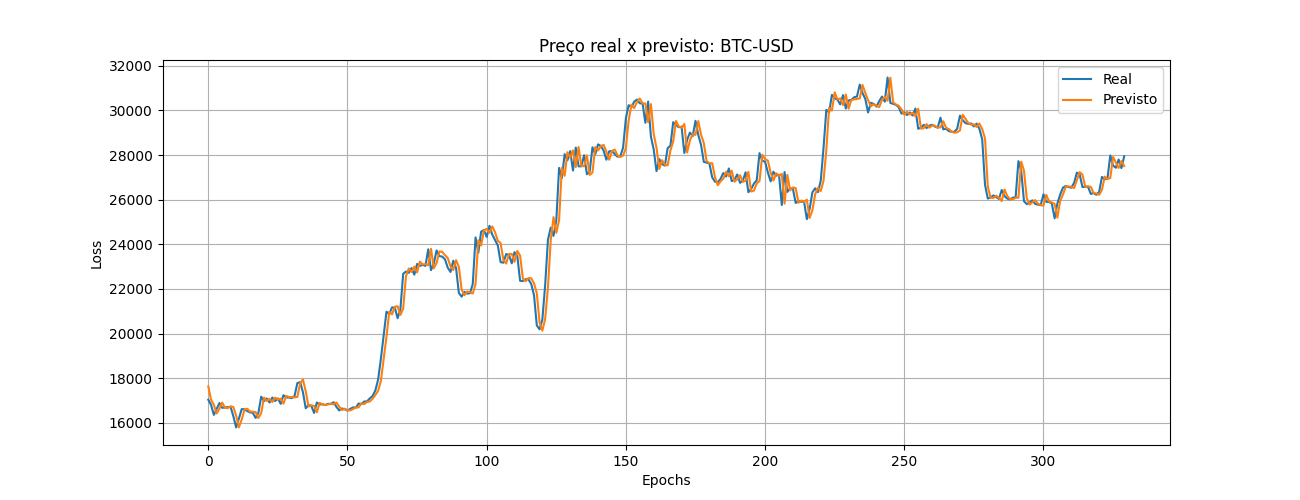

In [26]:
# Plota o gráfico comparativo entre os valores reais x previstos
epochs = range(len(y_test))
plt.figure(figsize=(13, 5))
plt.plot(epochs, real_prices, label='Real')
plt.plot(epochs, predictions, label='Previsto')
plt.title(f'Preço real x previsto: {SYMBOL}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.semilogy()
plt.legend()
plt.grid()

plt.show()

In [20]:
# Cria um Dataframe para comparação dos valores reais x previstos
df_prices = pd.DataFrame(real_prices, columns=['Real'])
df_prices['Previsto'] = predictions
df_prices['%Diferença'] = np.abs((df_prices['Real'] - df_prices['Previsto']) / df_prices['Real'] * 100)

print(f'Diferença min: {df_prices["%Diferença"].abs().min()}')
print(f'Diferença max: {df_prices["%Diferença"].abs().max()}')

# Exibe detalhes dos resultados
df_prices.describe()

Diferença min: 0.009825820277148522
Diferença max: 8.866760465696919


,Real,Previsto,%Diferença
count,330.000000,330.000000,330.000000
mean,24900.524618,24883.050748,1.467376
std,4597.041597,4607.956197,1.616093
min,15787.284180,15792.821940,0.009826
25%,22355.682129,22276.485687,0.321549
50%,26392.178711,26409.740333,0.932790
75%,28331.660156,28322.937722,1.962764
max,31476.048828,31463.585634,8.866760


In [21]:
# Avaliação pela métrica MAPE
mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(real_prices, predictions)
mape_result = mape.result().numpy()

print(f'MAPE: {mape_result}')

MAPE: 1.4673759937286377


In [22]:
# Reseta a sessão do tensorflow
tf.keras.backend.clear_session()

# Finaliza as figuras
plt.close('all')

In [23]:
# Exporta o modelo treinado para ser utilizado em alguma aplicação
model.save(f'{model.name}_{SYMBOL}.keras')

In [24]:
# Exporta os dados de treinamento para um arquivo .csv
data_train.to_csv(f'{model.name}_data_train_{SYMBOL}.csv')